In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 특정 텍스트의 유사한 텍스트 찾기 함수
def find_nbrs(idx, dist_matrix, top_n=10):
    dist_row = dist_matrix[idx]
    nbrs = dist_row.argsort()[:top_n]
    return nbrs

# 각 리뷰의 이웃들의 difference 값 비율과 거리 값을 계산하는 함수
def calc_diff_ratios_dists(nbrs_dict, dist_matrix):
    ratios = []
    dists = []
    for idx, nbrs in nbrs_dict.items():
        nbr_diffs = [eng.loc[nbr_idx, 'difference'] for nbr_idx in nbrs]
        diff_1_ratio = nbr_diffs.count(1) / len(nbr_diffs)
        ratios.append(diff_1_ratio)
        nbr_dists = [dist_matrix[idx, nbr_idx] for nbr_idx in nbrs]
        dists.extend(nbr_dists)
    return ratios, dists

# 요약 통계 계산 함수
def calculate_summary_statistics(data):
    summary = {
        'mean': np.mean(data),
        'std': np.std(data),
        'min': np.min(data),
        '25%': np.percentile(data, 25),
        'median': np.median(data),
        '75%': np.percentile(data, 75),
        'max': np.max(data)
    }
    return summary

# 요약 통계 출력 및 저장 함수
def print_and_save_summary_statistics(file, title, summary):
    summary_str = f"Summary statistics for {title}:\n"
    for key, value in summary.items():
        summary_str += f"{key}: {value:.4f}\n"
    summary_str += "\n"
    print(summary_str)
    file.write(summary_str)

# 교집합/합집합 점수 계산 함수
def calc_iou(neighbors_1, neighbors_2):
    set_1 = set(neighbors_1)
    set_2 = set(neighbors_2)
    intersection = len(set_1.intersection(set_2))
    union = len(set_1.union(set_2))
    return intersection / union if union != 0 else 0

In [3]:
# 작업 디렉토리 설정
os.chdir('C:/Users/UOS/Desktop/Agoda-Data/raw')

# 데이터 로드
eng = pd.read_csv("eng.csv", index_col=0)
eng = eng.reset_index(drop=True)


# 작업 디렉토리 변경
os.chdir('C:/Users/UOS/Desktop/Agoda-Data/embedding')

# 거리 행렬 로드
cnt_ham_dist = np.load('cnt_ham_distances.npy')
tf_l2_dist = np.load('tf_l2_distances.npy')

# 대각 원소를 모두 1로 설정
large_val = 1e6
np.fill_diagonal(cnt_ham_dist, large_val)
np.fill_diagonal(tf_l2_dist, large_val)

# 작업 디렉토리 변경
os.chdir('C:/Users/UOS/proj_0/neighborhood/')

In [4]:
# 이웃의 수
nbds_cnt = [10, 50, 100, 200]

# 빈 리스트 생성
ratios_all = {'cnt': {'diff_1': [], 'diff_0': []}, 'tf': {'diff_1': [], 'diff_0': []}}
dists_all = {'cnt': {'diff_1': [], 'diff_0': []}, 'tf': {'diff_1': [], 'diff_0': []}}

# 각 이웃의 수에 대해 계산
for n in nbds_cnt:
    diff_1_idx = eng[eng['difference'] == 1].index
    diff_1_nbrs_cnt = {i: find_nbrs(i, cnt_ham_dist, n) for i in diff_1_idx}
    diff_1_nbrs_tf = {i: find_nbrs(i, tf_l2_dist, n) for i in diff_1_idx}

    diff_0_idx = eng[eng['difference'] == 0].index
    diff_0_nbrs_cnt = {i: find_nbrs(i, cnt_ham_dist, n) for i in diff_0_idx}
    diff_0_nbrs_tf = {i: find_nbrs(i, tf_l2_dist, n) for i in diff_0_idx}

    # Hamming distance
    diff_1_ratios_cnt, diff_1_dists_cnt = calc_diff_ratios_dists(diff_1_nbrs_cnt, cnt_ham_dist)
    diff_0_ratios_cnt, diff_0_dists_cnt = calc_diff_ratios_dists(diff_0_nbrs_cnt, cnt_ham_dist)

    # TF-IDF L2 distance
    diff_1_ratios_tf, diff_1_dists_tf = calc_diff_ratios_dists(diff_1_nbrs_tf, tf_l2_dist)
    diff_0_ratios_tf, diff_0_dists_tf = calc_diff_ratios_dists(diff_0_nbrs_tf, tf_l2_dist)

    ratios_all['cnt']['diff_1'].append(diff_1_ratios_cnt)
    ratios_all['cnt']['diff_0'].append(diff_0_ratios_cnt)
    dists_all['cnt']['diff_1'].append(diff_1_dists_cnt)
    dists_all['cnt']['diff_0'].append(diff_0_dists_cnt)

    ratios_all['tf']['diff_1'].append(diff_1_ratios_tf)
    ratios_all['tf']['diff_0'].append(diff_0_ratios_tf)
    dists_all['tf']['diff_1'].append(diff_1_dists_tf)
    dists_all['tf']['diff_0'].append(diff_0_dists_tf)

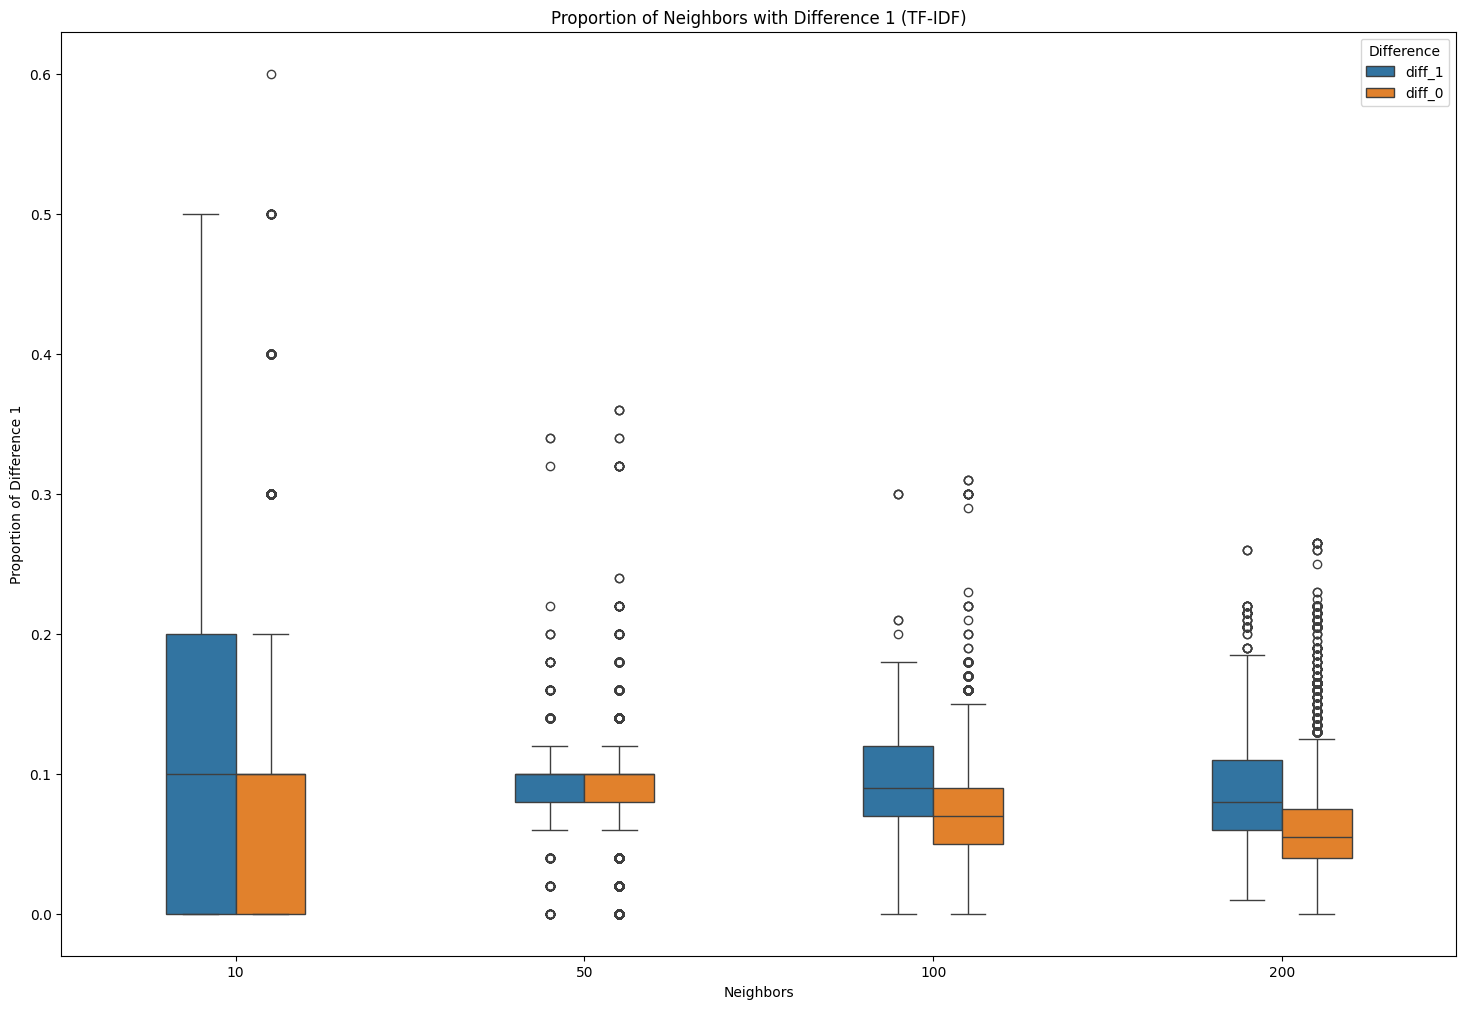

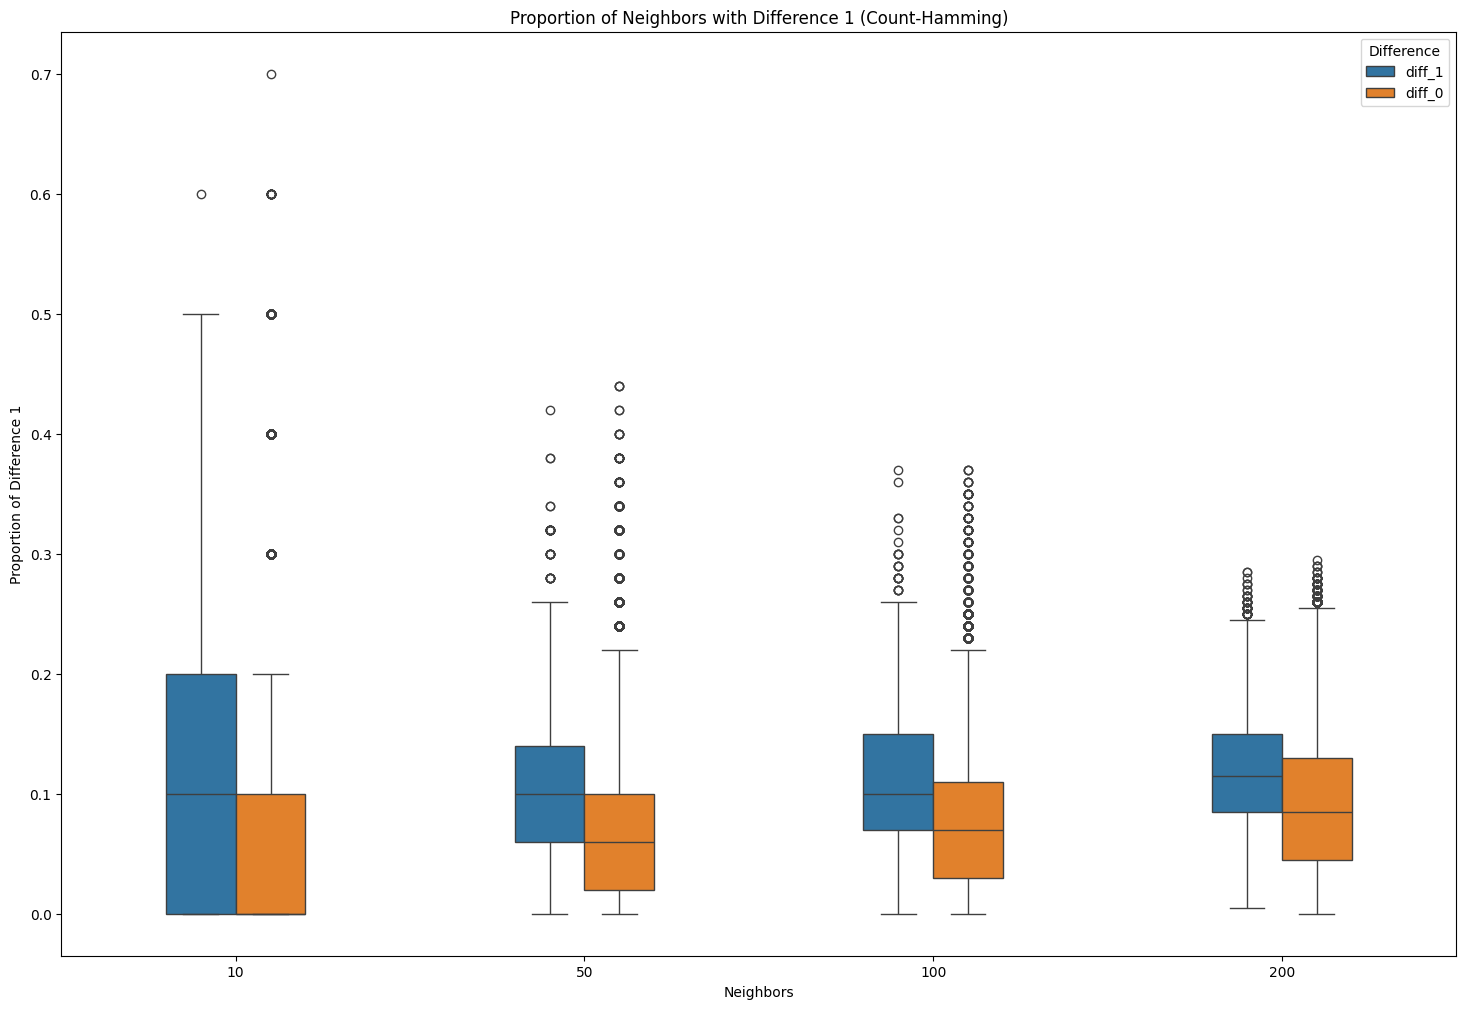

In [5]:
# Seaborn을 사용하여 TF-IDF L2 설정으로 Boxplot 생성
plt.figure(figsize=(18, 12))

# 이웃 수와 label에 따라 데이터를 준비합니다.
plot_data = []

for n in nbds_cnt:
    for label in ['diff_1', 'diff_0']:
        for ratio in ratios_all['tf'][label][nbds_cnt.index(n)]:
            plot_data.append({
                'Neighbors': n,
                'Difference': label,
                'Proportion': ratio
            })

# 데이터프레임으로 변환
plot_df = pd.DataFrame(plot_data)

# Boxplot 생성
sns.boxplot(x='Neighbors', y='Proportion', hue='Difference', data=plot_df, dodge=True, width=0.4)
plt.title('Proportion of Neighbors with Difference 1 (TF-IDF)')
plt.ylabel('Proportion of Difference 1')
plt.show()

# Seaborn을 사용하여 Count-Hamming 설정으로 Boxplot 생성
plt.figure(figsize=(18, 12))

# 이웃 수와 label에 따라 데이터를 준비합니다.
plot_data = []

for n in nbds_cnt:
    for label in ['diff_1', 'diff_0']:
        for ratio in ratios_all['cnt'][label][nbds_cnt.index(n)]:
            plot_data.append({
                'Neighbors': n,
                'Difference': label,
                'Proportion': ratio
            })

# 데이터프레임으로 변환
plot_df = pd.DataFrame(plot_data)

# Boxplot 생성
sns.boxplot(x='Neighbors', y='Proportion', hue='Difference', data=plot_df, dodge=True, width=0.4)
plt.title('Proportion of Neighbors with Difference 1 (Count-Hamming)')
plt.ylabel('Proportion of Difference 1')
plt.show()

In [6]:
plot_df

,Neighbors,Difference,Proportion
0,10,diff_1,0.000
1,10,diff_1,0.000
2,10,diff_1,0.100
3,10,diff_1,0.000
4,10,diff_1,0.000
...,...,...,...
66107,200,diff_0,0.145
66108,200,diff_0,0.045
66109,200,diff_0,0.160
66110,200,diff_0,0.115


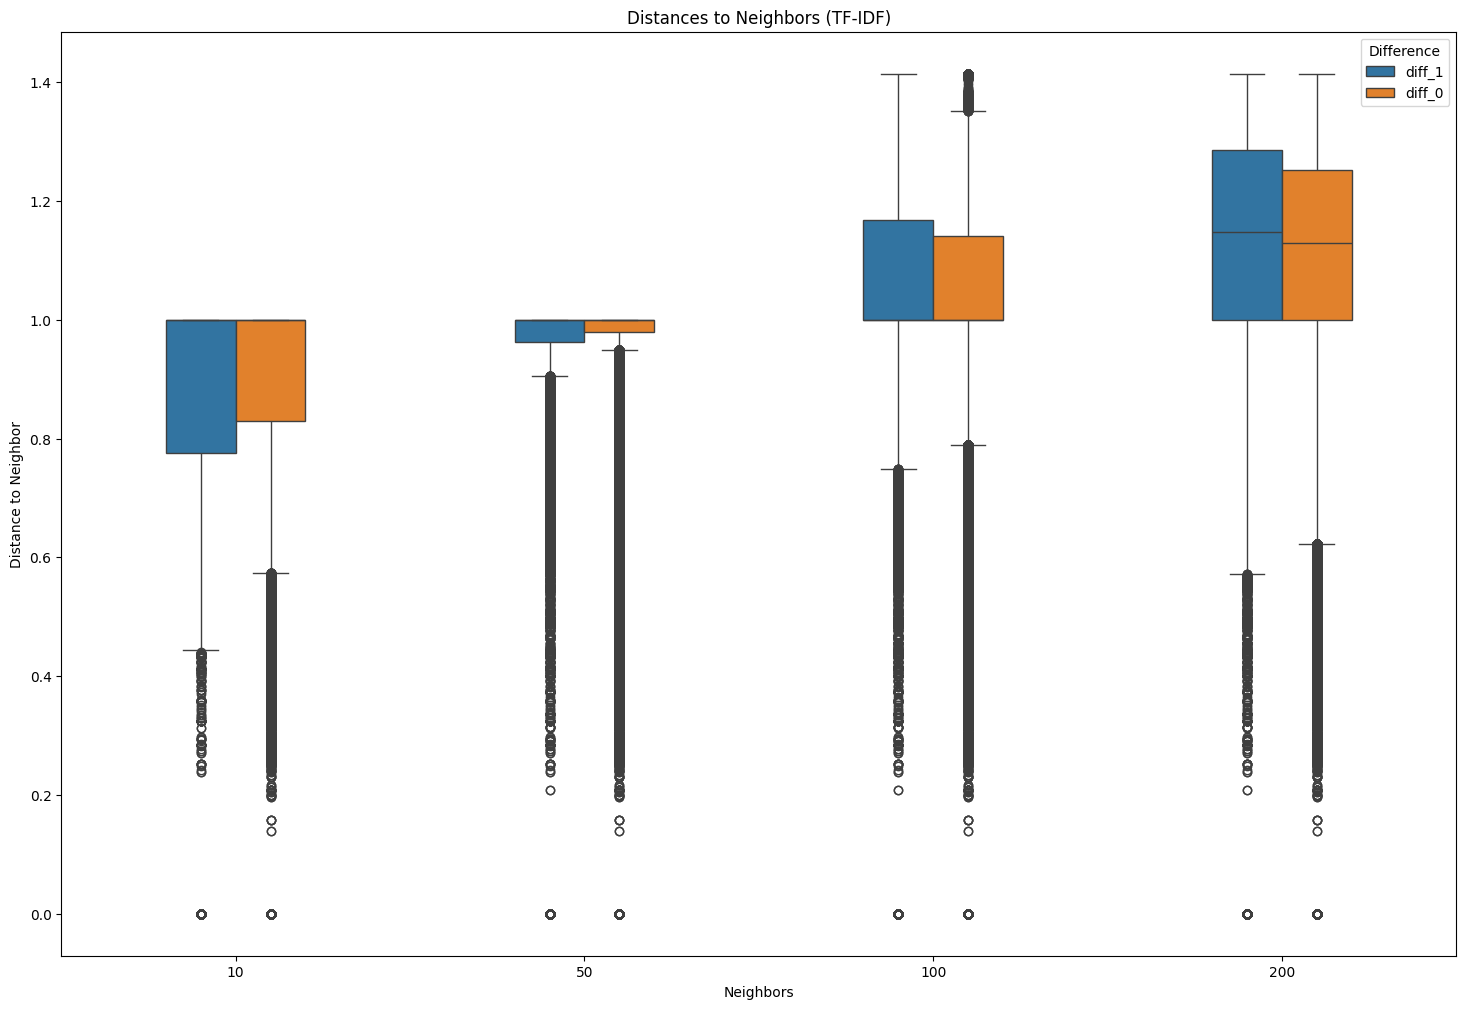

In [7]:
# Seaborn을 사용하여 TF-IDF L2 설정으로 Boxplot 생성
plt.figure(figsize=(18, 12))

# 이웃 수와 label에 따라 데이터를 준비합니다.
plot_data = []

for n in nbds_cnt:
    for label in ['diff_1', 'diff_0']:
        for distance in dists_all['tf'][label][nbds_cnt.index(n)]:
            plot_data.append({
                'Neighbors': n,
                'Difference': label,
                'Distance': distance
            })

# 데이터프레임으로 변환
plot_df = pd.DataFrame(plot_data)

# Boxplot 생성
sns.boxplot(x='Neighbors', y='Distance', hue='Difference', data=plot_df, dodge=True, width=0.4)
plt.title('Distances to Neighbors (TF-IDF)')
plt.ylabel('Distance to Neighbor')
plt.show()

In [8]:
plot_df

,Neighbors,Difference,Distance
0,10,diff_1,1.000000
1,10,diff_1,1.000000
2,10,diff_1,1.000000
3,10,diff_1,1.000000
4,10,diff_1,1.000000
...,...,...,...
5950075,200,diff_0,1.324051
5950076,200,diff_0,1.324122
5950077,200,diff_0,1.324939
5950078,200,diff_0,1.325110


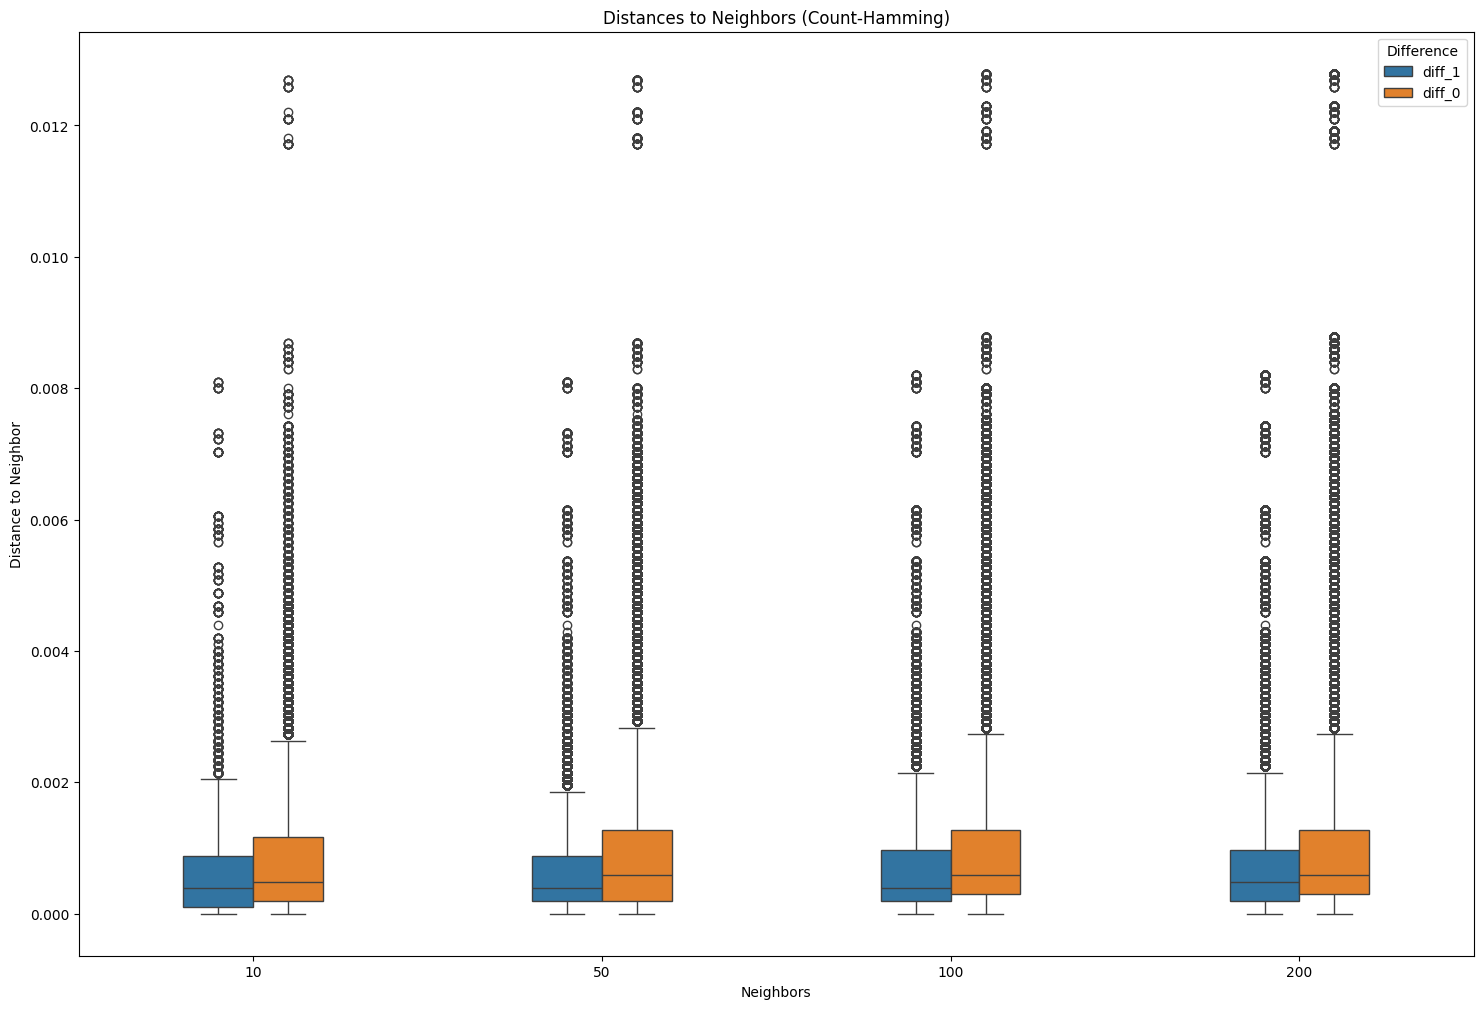

In [9]:
# Seaborn을 사용하여 Count-Hamming 설정으로 Boxplot 생성
plt.figure(figsize=(18, 12))

# 이웃 수와 label에 따라 데이터를 준비합니다.
plot_data = []

for n in nbds_cnt:
    for label in ['diff_1', 'diff_0']:
        for distance in dists_all['cnt'][label][nbds_cnt.index(n)]:
            plot_data.append({
                'Neighbors': n,
                'Difference': label,
                'Distance': distance
            })

# 데이터프레임으로 변환
plot_df = pd.DataFrame(plot_data)

# Boxplot 생성
sns.boxplot(x='Neighbors', y='Distance', hue='Difference', data=plot_df, dodge=True, width=0.4)
plt.title('Distances to Neighbors (Count-Hamming)')
plt.ylabel('Distance to Neighbor')
plt.show()

In [10]:
plot_df

,Neighbors,Difference,Distance
0,10,diff_1,0.001464
1,10,diff_1,0.001464
2,10,diff_1,0.001562
3,10,diff_1,0.001562
4,10,diff_1,0.001562
...,...,...,...
5950075,200,diff_0,0.000781
5950076,200,diff_0,0.000781
5950077,200,diff_0,0.000781
5950078,200,diff_0,0.000878


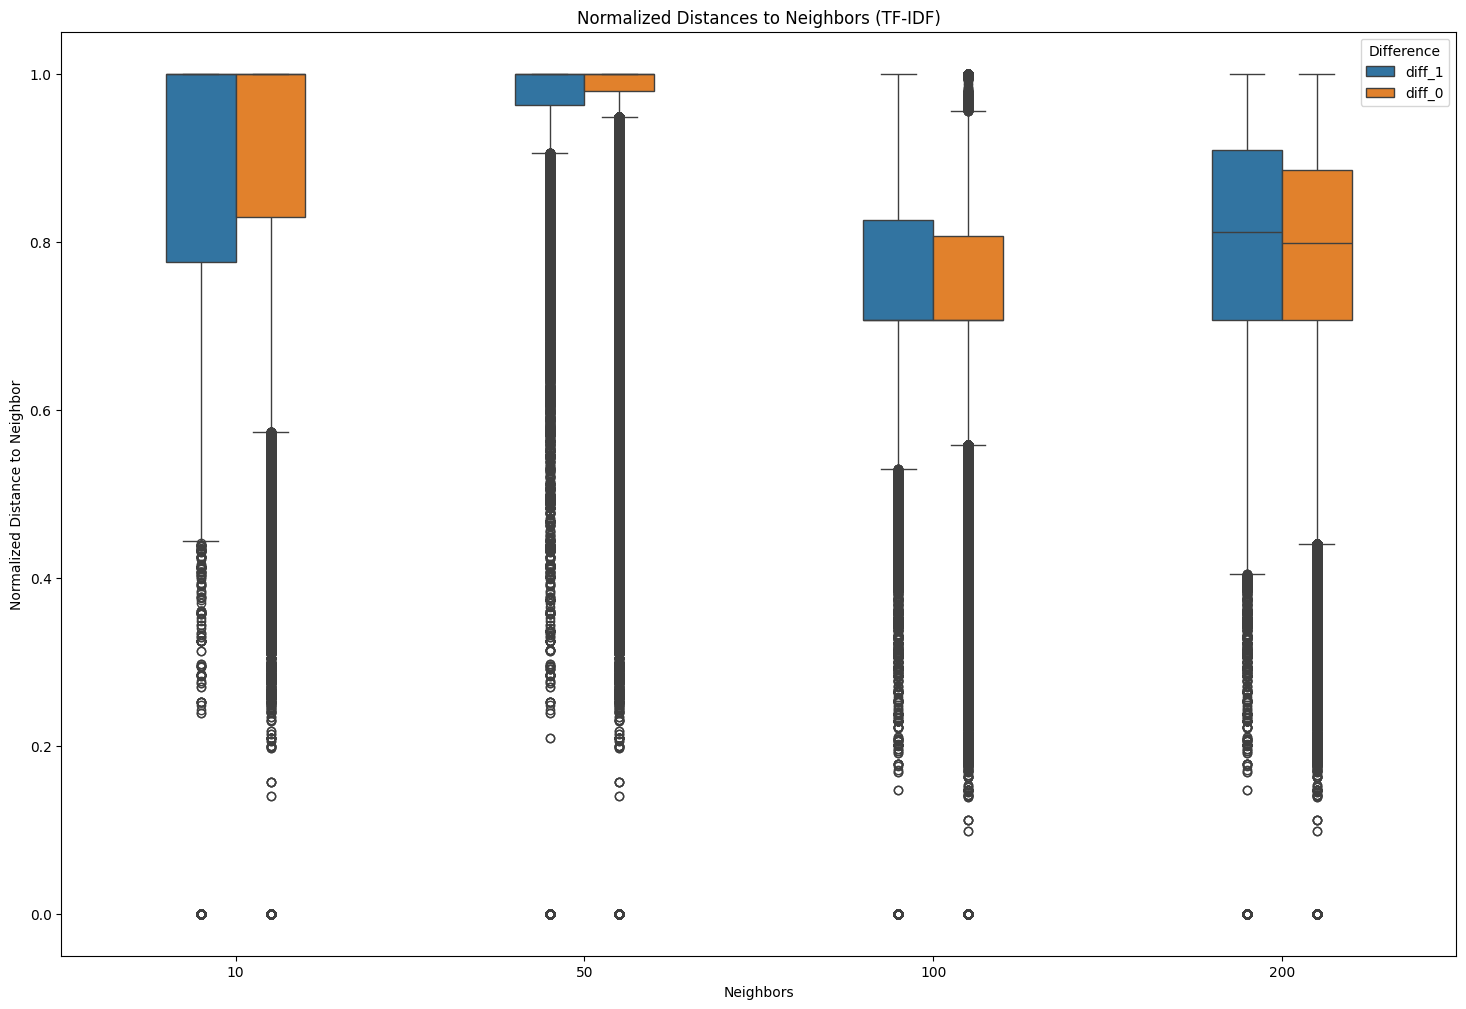

In [11]:
## minmiax scaling 진행
from sklearn.preprocessing import MinMaxScaler

# 거리값 정규화 함수
def normalize_distances(distances):
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(np.array(distances).reshape(-1, 1)).flatten()
    return normalized

# Seaborn을 사용하여 TF-IDF L2 설정으로 Boxplot 생성
plt.figure(figsize=(18, 12))

# 이웃 수와 label에 따라 데이터를 준비합니다.
plot_data = []

for n in nbds_cnt:
    for label in ['diff_1', 'diff_0']:
        distances = dists_all['tf'][label][nbds_cnt.index(n)]
        normalized_distances = normalize_distances(distances)
        for distance in normalized_distances:
            plot_data.append({
                'Neighbors': n,
                'Difference': label,
                'Distance': distance
            })

# 데이터프레임으로 변환
plot_df = pd.DataFrame(plot_data)

# Boxplot 생성
sns.boxplot(x='Neighbors', y='Distance', hue='Difference', data=plot_df, dodge=True, width=0.4)
plt.title('Normalized Distances to Neighbors (TF-IDF)')
plt.ylabel('Normalized Distance to Neighbor')
plt.show()

In [12]:
plot_df

,Neighbors,Difference,Distance
0,10,diff_1,1.000000
1,10,diff_1,1.000000
2,10,diff_1,1.000000
3,10,diff_1,1.000000
4,10,diff_1,1.000000
...,...,...,...
5950075,200,diff_0,0.936245
5950076,200,diff_0,0.936296
5950077,200,diff_0,0.936874
5950078,200,diff_0,0.936994


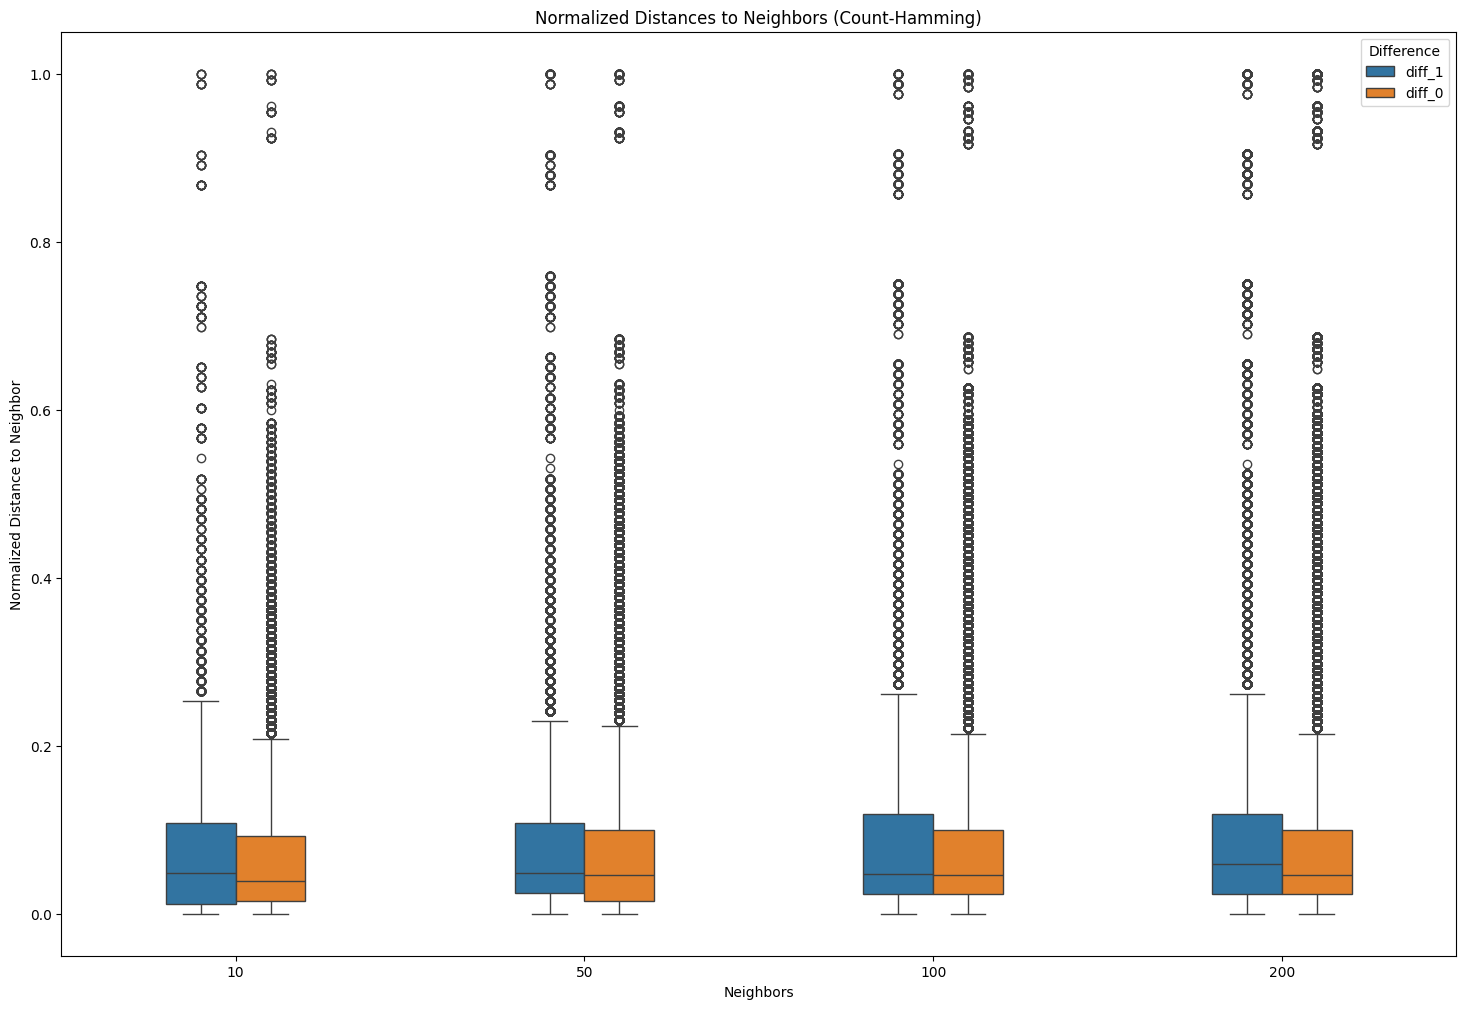

In [13]:
# Seaborn을 사용하여 Count-Hamming 설정으로 Boxplot 생성
plt.figure(figsize=(18, 12))

# 이웃 수와 label에 따라 데이터를 준비합니다.
plot_data = []

for n in nbds_cnt:
    for label in ['diff_1', 'diff_0']:
        distances = dists_all['cnt'][label][nbds_cnt.index(n)]
        normalized_distances = normalize_distances(distances)
        for distance in normalized_distances:
            plot_data.append({
                'Neighbors': n,
                'Difference': label,
                'Distance': distance
            })

# 데이터프레임으로 변환
plot_df = pd.DataFrame(plot_data)

# Boxplot 생성
sns.boxplot(x='Neighbors', y='Distance', hue='Difference', data=plot_df, dodge=True, width=0.4)
plt.title('Normalized Distances to Neighbors (Count-Hamming)')
plt.ylabel('Normalized Distance to Neighbor')
plt.show()

In [14]:
plot_df

,Neighbors,Difference,Distance
0,10,diff_1,0.180723
1,10,diff_1,0.180723
2,10,diff_1,0.192771
3,10,diff_1,0.192771
4,10,diff_1,0.192771
...,...,...,...
5950075,200,diff_0,0.061069
5950076,200,diff_0,0.061069
5950077,200,diff_0,0.061069
5950078,200,diff_0,0.068702


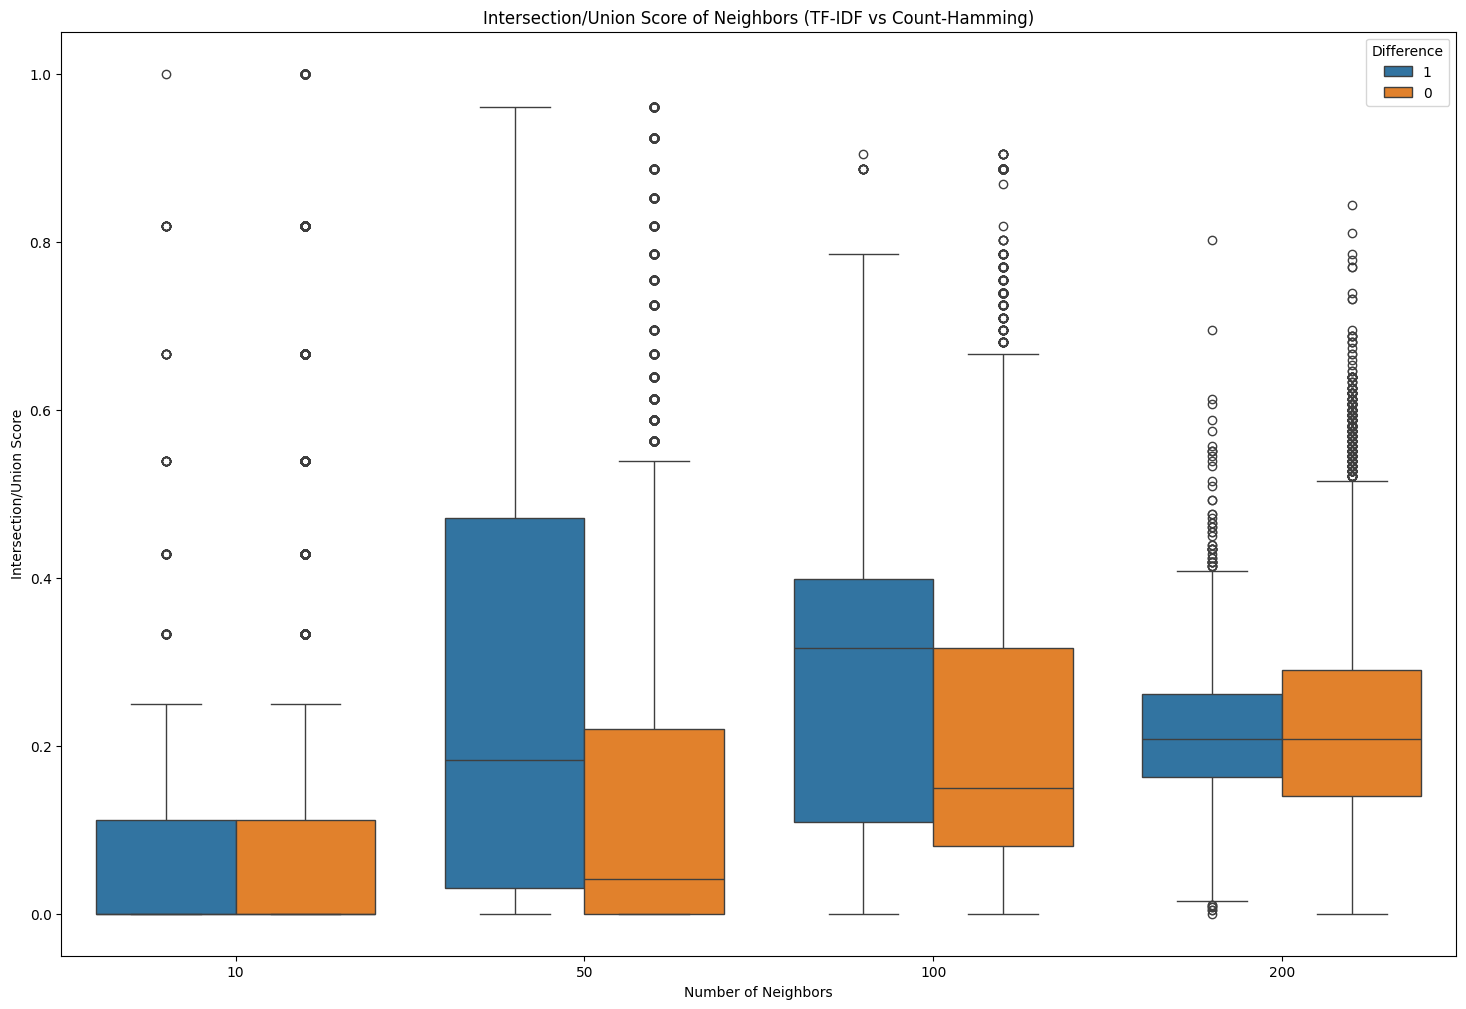

In [15]:
# 결과 저장 리스트
scores_diff_1 = {n: [] for n in nbds_cnt}
scores_diff_0 = {n: [] for n in nbds_cnt}

# 각 행에 대해 계산
for idx in range(cnt_ham_dist.shape[0]):
    for n in nbds_cnt:
        neighbors_cnt = find_nbrs(idx, cnt_ham_dist, n)
        neighbors_tf = find_nbrs(idx, tf_l2_dist, n)
        score = calc_iou(neighbors_cnt, neighbors_tf)
        
        if eng.loc[idx, 'difference'] == 1:
            scores_diff_1[n].append(score)
        else:
            scores_diff_0[n].append(score)

# Boxplot 생성 데이터 준비
plot_data = []

for n in nbds_cnt:
    for score in scores_diff_1[n]:
        plot_data.append({
            'Neighbors': n,
            'Score': score,
            'Difference': '1'
        })
    for score in scores_diff_0[n]:
        plot_data.append({
            'Neighbors': n,
            'Score': score,
            'Difference': '0'
        })

# 데이터프레임으로 변환
plot_df = pd.DataFrame(plot_data)

# Boxplot 생성
plt.figure(figsize=(18, 12))
sns.boxplot(x='Neighbors', y='Score', hue='Difference', data=plot_df, dodge=True)
plt.title('Intersection/Union Score of Neighbors (TF-IDF vs Count-Hamming)')
plt.xlabel('Number of Neighbors')
plt.ylabel('Intersection/Union Score')
plt.show()

In [16]:
plot_df

,Neighbors,Score,Difference
0,10,0.000000,1
1,10,0.176471,1
2,10,0.250000,1
3,10,0.052632,1
4,10,0.000000,1
...,...,...,...
66107,200,0.384083,0
66108,200,0.257862,0
66109,200,0.169591,0
66110,200,0.433692,0


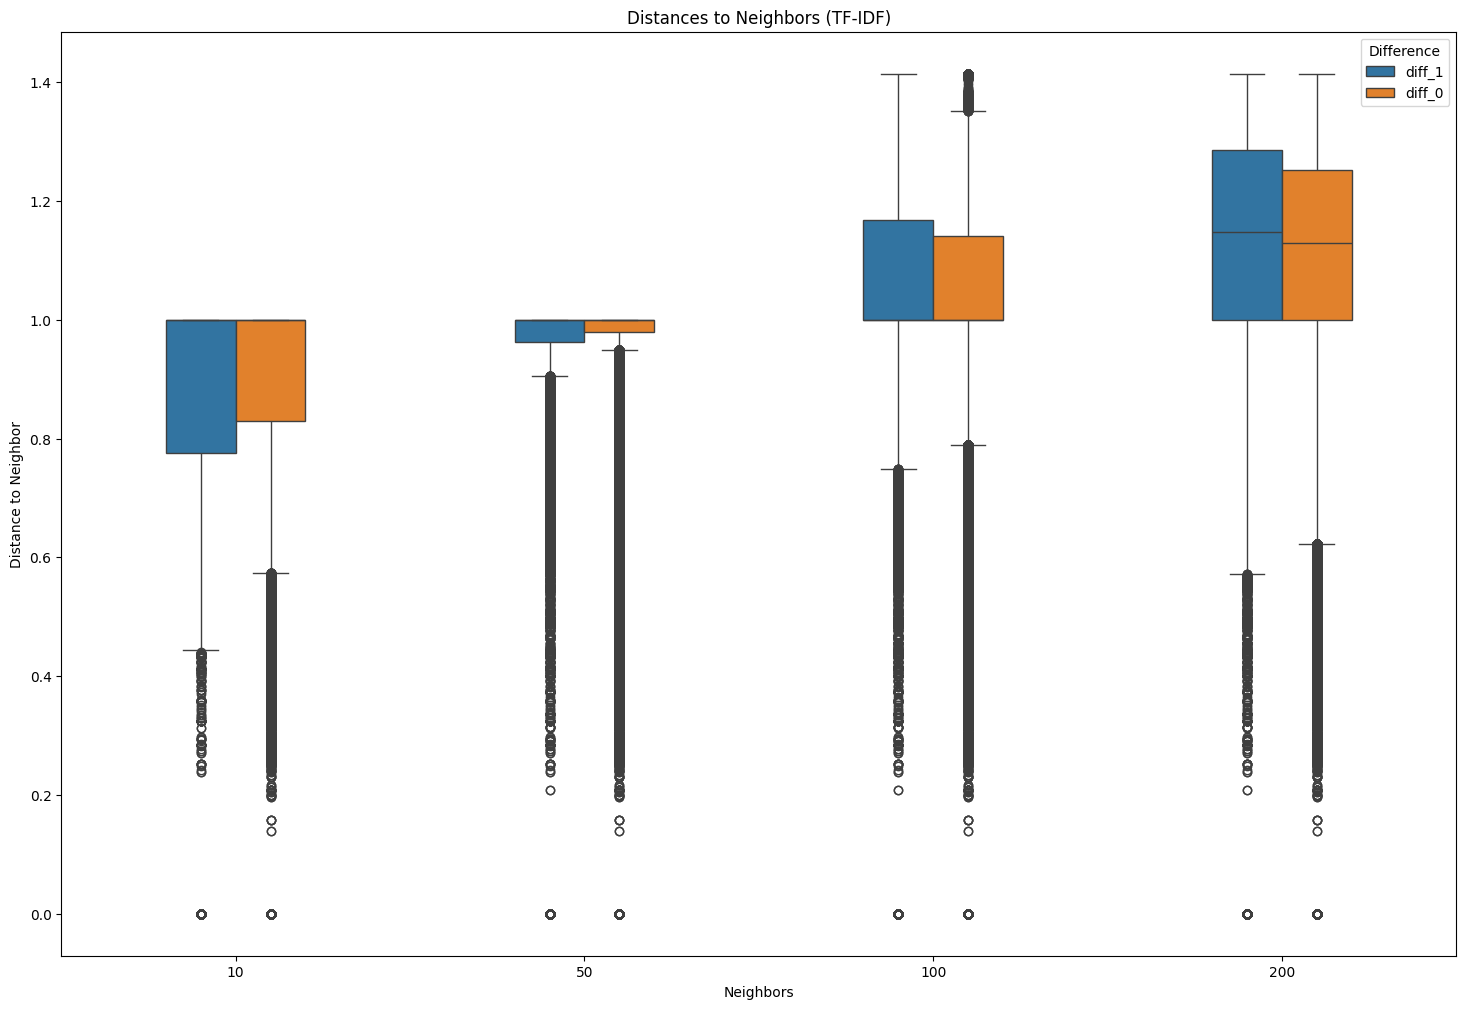

In [19]:
# Boxplot을 위한 데이터 준비
plot_data = []

for n in nbds_cnt:
    for label in ['diff_1', 'diff_0']:
        for distance in dists_all['tf'][label][nbds_cnt.index(n)]:
            plot_data.append({
                'Neighbors': n,
                'Difference': label,
                'Distance': distance
            })

# 데이터프레임으로 변환
plot_df = pd.DataFrame(plot_data)

# Boxplot 생성
plt.figure(figsize=(18, 12))
sns.boxplot(x='Neighbors', y='Distance', hue='Difference', data=plot_df, dodge=True, width=0.4)
plt.title('Distances to Neighbors (TF-IDF)')
plt.ylabel('Distance to Neighbor')
plt.show()

In [20]:
plot_df

,Neighbors,Difference,Distance
0,10,diff_1,1.000000
1,10,diff_1,1.000000
2,10,diff_1,1.000000
3,10,diff_1,1.000000
4,10,diff_1,1.000000
...,...,...,...
5950075,200,diff_0,1.324051
5950076,200,diff_0,1.324122
5950077,200,diff_0,1.324939
5950078,200,diff_0,1.325110


NameError: name 'cnt_ham_sim' is not defined

In [24]:
plot_df

,Neighbors,Difference,Distance
0,10,diff_1,1.000000
1,10,diff_1,1.000000
2,10,diff_1,1.000000
3,10,diff_1,1.000000
4,10,diff_1,1.000000
...,...,...,...
5950075,200,diff_0,1.324051
5950076,200,diff_0,1.324122
5950077,200,diff_0,1.324939
5950078,200,diff_0,1.325110
